# Análise exploratória e pré-processamento

Objetivo: Análise do conjunto de dados Health Insurance Lead Prediction Dataset e pré-processamento dos dados para uso posterior no projeto.

---

Problema a ser resolvido:

Um determinado site de um plano de saúde oferece planos para os visitantes.

Utilizando algumas informações, o site então recomenda um plano de saúde específico para o visitante.

Se esse visitante clica e preenche o formulário solicitando um plano de saúde, ele é considerado uma lead (pessoa que demonstrou interesse) e pode ser encaminhado para a equipe de vendas para, eventualmente, contratar o plano.

Uma ferramenta de predição eficiente para prever quando um cliente demonstraria interesse ou não é uma ferramenta eficiente para a análise do negócio, podendo ser utilizada para modificar o comportamento do site com novos visitantes ou modificar os planos que são oferecidos para melhorar as vendas.

In [1]:
#Installing used modules in SageMaker notebook
!pip install s3fs==2022.01.0
%pip install phik
%pip install imblearn
%pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to re

In [2]:
#Sagemaker Modules
import boto3

In [3]:
#Importing python modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import phik
sns.set_palette('viridis')
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from yellowbrick.classifier import ConfusionMatrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
import warnings
warnings.filterwarnings("ignore") #Filtering some warnings for better presentation

In [5]:
bucket='trabalho-ifsp-campinas-interdisciplinar-2022-2'

### 1. Carregando os dados

In [6]:
#Loading the dataset from GitHub repo and saving into S3 Bucket 
github_raw_dataset = pd.read_csv('./datasets/raw/Health Insurance Lead Prediction Raw Data.csv')
github_raw_dataset.to_csv('s3://trabalho-ifsp-campinas-interdisciplinar-2022-2/raw_dataset.csv', index = False)
s3_dataset = pd.read_csv('s3://trabalho-ifsp-campinas-interdisciplinar-2022-2/raw_dataset.csv')
github_raw_dataset.equals(s3_dataset) #Checking if the datasets loaded correctly

True

In [7]:
#loading the raw data
df = pd.read_csv('s3://trabalho-ifsp-campinas-interdisciplinar-2022-2/raw_dataset.csv')
df

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50877,50878,C4,845,Rented,Individual,22,22,No,X3,NaN,NaN,18,7704.0,0
50878,50879,C5,4188,Rented,Individual,27,27,No,X3,7.0,3.0,4,5408.0,0
50879,50880,C1,442,Rented,Individual,63,63,No,X2,14+,1.0,12,11374.0,0
50880,50881,C1,4,Owned,Joint,71,49,No,X2,2.0,2.0,16,28179.2,1


Das informações do dataset, essa é a descrição das colunas:


 | Coluna | Definição | 
 | --- | --- |
 | ID Unique | Identificador da coluna | 
 | City_Code | Código da cidade dos clientes| 
 | Region_Code | Código da região dos clientes | 
 | Accomodation_Type | Se o cliente é dono ou não da casa | 
 | Reco_Insurance_Type | Tipo de seguro recomendado, individual ou em conjunto | 
 | Upper_Age | Idade máxima do cliente | 
 | Lower_Age | Idade mínima do cliente | 
 | Is_Spouse | Se os segurados são casados, no caso de conta conjunta | 
 | Health_Indicator | Indicadores de saúde do cliente | 
 | Holding_Policy_Duration | Duração em anos do seguro, se o cliente já era segurado da compania | 
 | Holding_Policy_Type | Tipo do seguro, se o cliente já era segurado | 
 | Reco_Policy_Cat | Tipo de seguro recomandado para o cliente | 
 | Reco_Policy_Premium Annual | Prêmio recomendado para o cliente | 
 | Response | Se o cliente solicitou ou não o plano de saúde, variável alvo |

In [8]:
#ID column can be dropped
df.drop(columns=['ID'], inplace=True)
df.rename(columns = {'Health Indicator':'Health_Indicator'}, inplace = True)

In [9]:
#Checking types of data and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   City_Code                50882 non-null  object 
 1   Region_Code              50882 non-null  int64  
 2   Accomodation_Type        50882 non-null  object 
 3   Reco_Insurance_Type      50882 non-null  object 
 4   Upper_Age                50882 non-null  int64  
 5   Lower_Age                50882 non-null  int64  
 6   Is_Spouse                50882 non-null  object 
 7   Health_Indicator         39191 non-null  object 
 8   Holding_Policy_Duration  30631 non-null  object 
 9   Holding_Policy_Type      30631 non-null  float64
 10  Reco_Policy_Cat          50882 non-null  int64  
 11  Reco_Policy_Premium      50882 non-null  float64
 12  Response                 50882 non-null  int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 5.0+ MB


Algumas variáveis estão no tipo 'object', por ter strings.

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Region_Code,50882.0,1732.788707,1424.081652,1.0,523.0,1391.0,2667.0,6194.0
Upper_Age,50882.0,44.856275,17.310271,18.0,28.0,44.0,59.0,75.0
Lower_Age,50882.0,42.738866,17.319375,16.0,27.0,40.0,57.0,75.0
Holding_Policy_Type,30631.0,2.439228,1.025923,1.0,1.0,3.0,3.0,4.0
Reco_Policy_Cat,50882.0,15.115188,6.340663,1.0,12.0,17.0,20.0,22.0
Reco_Policy_Premium,50882.0,14183.950069,6590.074873,2280.0,9248.0,13178.0,18096.0,43350.4
Response,50882.0,0.239947,0.427055,0.0,0.0,0.0,0.0,1.0


In [11]:
#Checking percent of NaN values
(df.isna().sum() / len(df)) * 100

City_Code                   0.000000
Region_Code                 0.000000
Accomodation_Type           0.000000
Reco_Insurance_Type         0.000000
Upper_Age                   0.000000
Lower_Age                   0.000000
Is_Spouse                   0.000000
Health_Indicator           22.976691
Holding_Policy_Duration    39.799929
Holding_Policy_Type        39.799929
Reco_Policy_Cat             0.000000
Reco_Policy_Premium         0.000000
Response                    0.000000
dtype: float64

O dataset possui algumas colunas com vários dados faltantes.

In [12]:
#Checking balance of target value
df['Response'].value_counts() / len(df) * 100

0    76.005267
1    23.994733
Name: Response, dtype: float64

O dataset está desbalanceado. A classe alvo representa 23,9% das entradas.

In [13]:
#Checking if there are duplicate rows
df[df.duplicated()].shape

(0, 13)

Não há linhas duplicadas.

### 2. Análise dos dados
#### 2.1 Checando correlações e características dos dados

In [14]:
#Checking the correlation of the data
df.corr().round(2)

,Region_Code,Upper_Age,Lower_Age,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
Region_Code,1.00,-0.01,-0.01,0.01,-0.07,-0.01,0.00
Upper_Age,-0.01,1.00,0.92,0.14,0.03,0.79,0.00
Lower_Age,-0.01,0.92,1.00,0.12,0.02,0.62,-0.00
Holding_Policy_Type,0.01,0.14,0.12,1.00,0.08,0.12,0.01
Reco_Policy_Cat,-0.07,0.03,0.02,0.08,1.00,0.06,0.11
Reco_Policy_Premium,-0.01,0.79,0.62,0.12,0.06,1.00,0.01
Response,0.00,0.00,-0.00,0.01,0.11,0.01,1.00


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


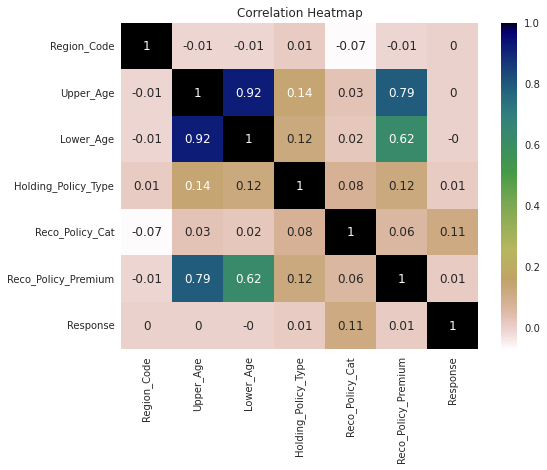

In [15]:
#Plotting the correlation matrix
plt.figure(figsize = (8,6))
sns.heatmap(df.corr().round(2), annot=True, cmap='gist_earth_r').set(title='Correlation Heatmap');

Aparentemente das features numéricas, a que mais se correlaciona com a variável alvo é o tipo de plano recomendado.

Podemos usar a matriz $\Phi_K$ (PhiK) de correlação para para achar algumas variáveis correlatas antes de mais processamento.

In [16]:
#Correlations using the 𝜙k (phi-k) matrix.
interval_cols = list(df._get_numeric_data().columns)
phik_matrix = df.phik_matrix(interval_cols = interval_cols)
phik_matrix

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health_Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
City_Code,1.000000,0.424883,0.228046,0.128042,0.241070,0.233354,0.122114,0.119192,0.183351,0.355218,0.503623,0.216918,0.000000
Region_Code,0.424883,1.000000,0.018516,0.020004,0.023406,0.014963,0.017596,0.027936,0.035292,0.039569,0.155283,0.030683,0.000000
Accomodation_Type,0.228046,0.018516,1.000000,0.304139,0.568576,0.502688,0.295456,0.127904,0.232629,0.230149,0.080038,0.473428,0.004132
Reco_Insurance_Type,0.128042,0.020004,0.304139,1.000000,0.320370,0.203250,0.982724,0.088294,0.083343,0.124979,0.040815,0.806581,0.013788
Upper_Age,0.241070,0.023406,0.568576,0.320370,1.000000,0.976992,0.284337,0.103069,0.357247,0.154263,0.072530,0.757116,0.019590
Lower_Age,0.233354,0.014963,0.502688,0.203250,0.976992,1.000000,0.164883,0.109438,0.313823,0.143680,0.083591,0.702981,0.008705
Is_Spouse,0.122114,0.017596,0.295456,0.982724,0.284337,0.164883,1.000000,0.110395,0.074634,0.138120,0.045328,0.706252,0.000000
Health_Indicator,0.119192,0.027936,0.127904,0.088294,0.103069,0.109438,0.110395,1.000000,0.029885,0.143580,0.085628,0.080725,0.000000
Holding_Policy_Duration,0.183351,0.035292,0.232629,0.083343,0.357247,0.313823,0.074634,0.029885,1.000000,0.161215,0.087694,0.242382,0.021558
Holding_Policy_Type,0.355218,0.039569,0.230149,0.124979,0.154263,0.143680,0.138120,0.143580,0.161215,1.000000,0.310628,0.123110,0.000000


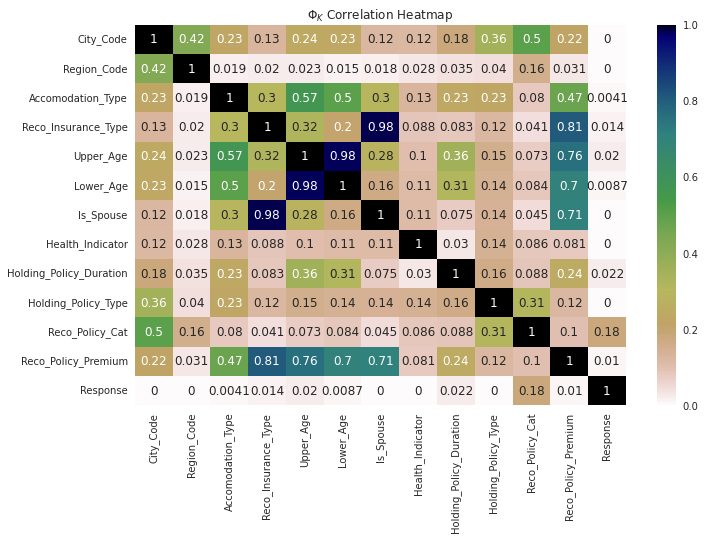

In [17]:
#Plotting the heatmap of the Phi-K correlation map
plt.figure(figsize = (11,7))
sns.heatmap(phik_matrix, annot=True, cmap='gist_earth_r').set(title=r'$\Phi_K$ Correlation Heatmap');

A matriz PhiK mostra que além da categoria, outros dados tem pouca correlação com a resposta, até o momento.

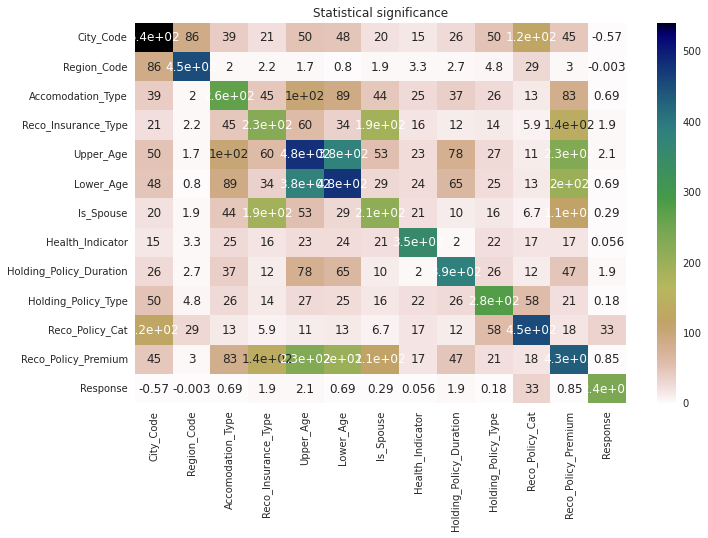

In [18]:
#Checking the statistical significance of the features
plt.figure(figsize = (11,7))
significance_matrix = df.significance_matrix(interval_cols=interval_cols).round(3).fillna(0)
sns.heatmap(significance_matrix, annot=True, cmap='gist_earth_r').set(title='Statistical significance');

Da mesma maneira, o tipo de plano ainda é o mais significante para a análise do resultado.

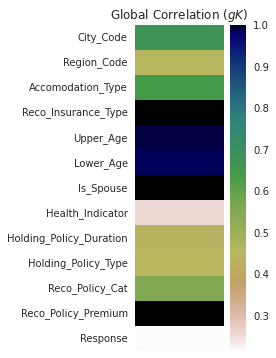

In [19]:
#PLotting the global correlation of the data
global_correlation, global_labels = df.global_phik(interval_cols=interval_cols)
plt.figure(figsize = (2,6))
sns.heatmap(global_correlation, xticklabels=[''], yticklabels=global_labels,cmap='gist_earth_r').set(title=r'Global Correlation ($gK$)');

Algumas variáveis tem alta correlação global com o dataset, em especial o tipo de seguro, as idades e o prêmio do seguro.

A análise dessa correlação com as duas matrizes acima não permite inferir qualquer correlação especial com o resultado.

#### 2.2 Analisando os valores

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


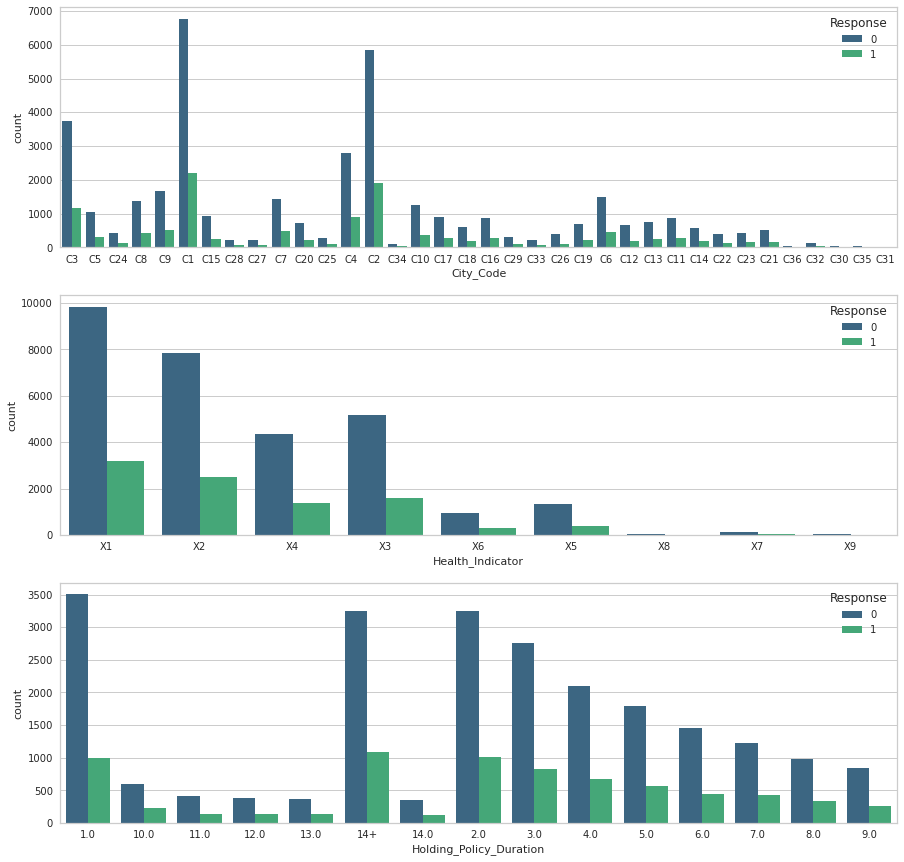

In [20]:
plt.figure(figsize = (15,15))
plt.subplot(3,1,1)
sns.countplot(x = 'City_Code', hue='Response',data = df, palette='viridis')
plt.subplot(3,1,2)
sns.countplot(x = 'Health_Indicator',  hue='Response', data = df, palette='viridis')
plt.subplot(3,1,3)
sns.countplot(x = 'Holding_Policy_Duration', hue='Response', data = df.sort_values(by=['Holding_Policy_Duration']), palette='viridis');

In [21]:
df['Health_Indicator'].value_counts()

X1    13010
X2    10332
X3     6762
X4     5743
X5     1727
X6     1280
X7      196
X8       78
X9       63
Name: Health_Indicator, dtype: int64

Não há diferença significativa nas respostas e nos dados categóricos, além da discrepância pela base de dados desbalanceada.

A coluna Holding_Policy_Duration na verdade é uma variável numérica. Só foi considerada 'object' pelo pandas porque o valor 14+ é uma string.

Já os indicadores de saúde não estão bem distribuídos.

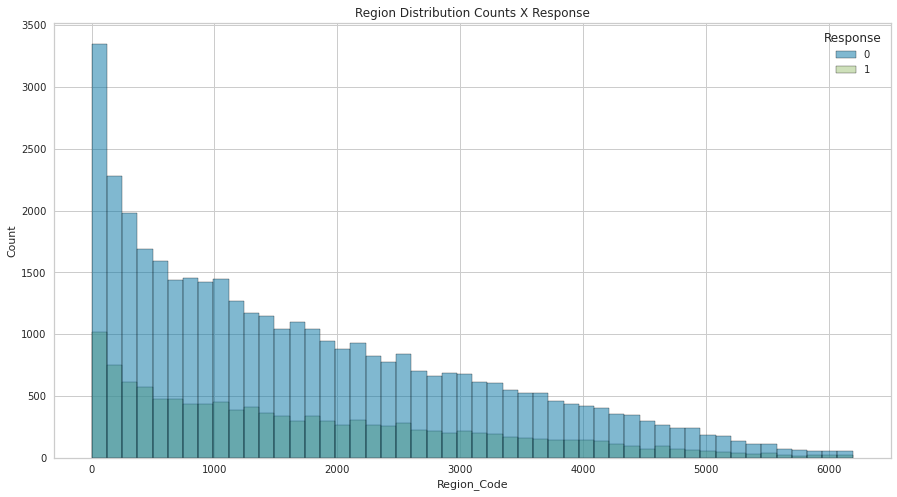

In [22]:
plt.figure(figsize = (15,8))
plot = sns.histplot(data=df, x='Region_Code', bins=50, hue='Response');
plt.title("Region Distribution Counts X Response")
plt.show()

A distribuição das regiões também não mostra nenhuma variância significativa em relação ao valor de resposta.

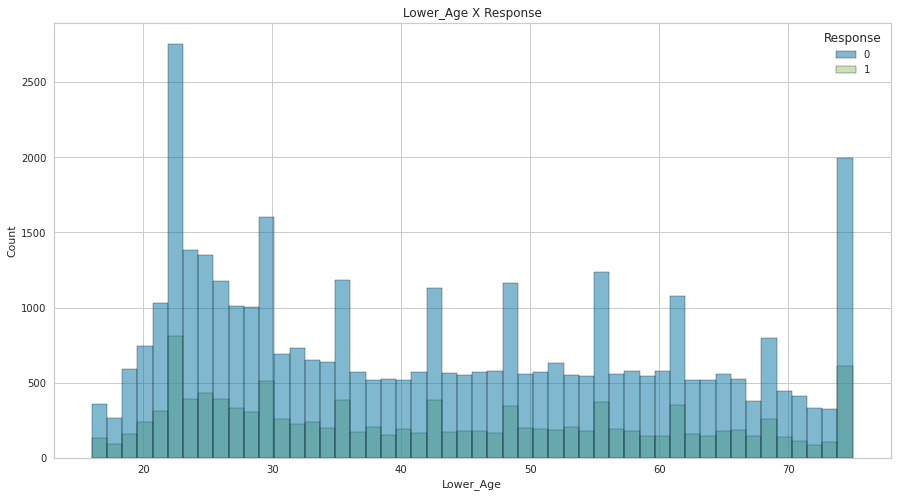

In [23]:
plt.figure(figsize = (15,8))
sns.histplot(data=df, x='Lower_Age', bins=50, hue='Response').set_title('Lower_Age X Response');

Apesar da idade mínima ter uma frequência maior por volta dos 22-23 anos, os demais valores estão relativamente bem distribuídos, com exceção do último.

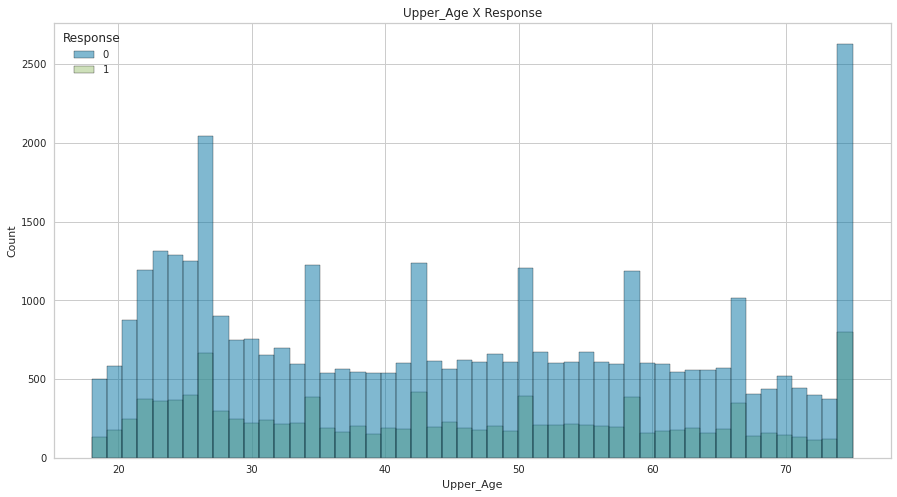

In [24]:
plt.figure(figsize = (15,8))
sns.histplot(data=df, x='Upper_Age', bins=50, hue='Response').set_title('Upper_Age X Response');

Idade maior também indica uma distribuição homogênea, novamente com exceçção aos maiores valores.

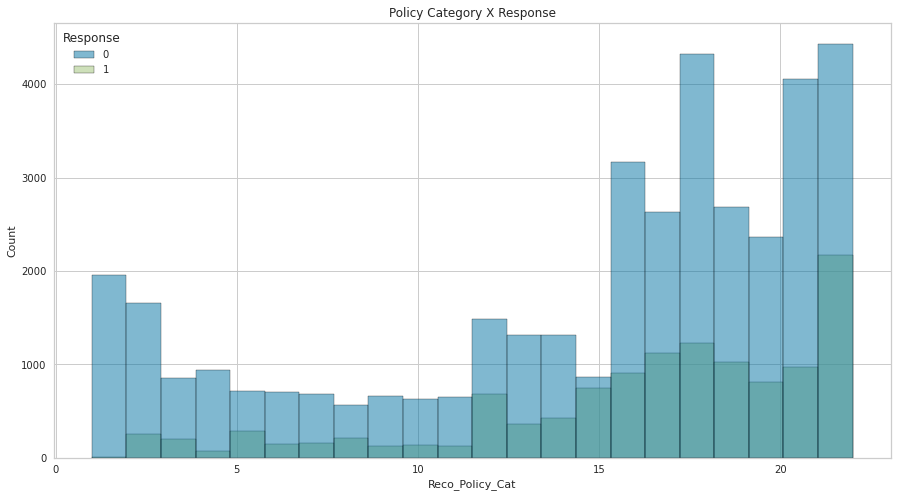

In [25]:
plt.figure(figsize = (15,8))
sns.histplot(data=df, x='Reco_Policy_Cat', bins=len(df['Reco_Policy_Cat'].unique()), hue='Response').set_title('Policy Category X Response');

Os valores por tipo de seguro oferecido também são homogênos, porém mais concentrados nas categorias maiores.

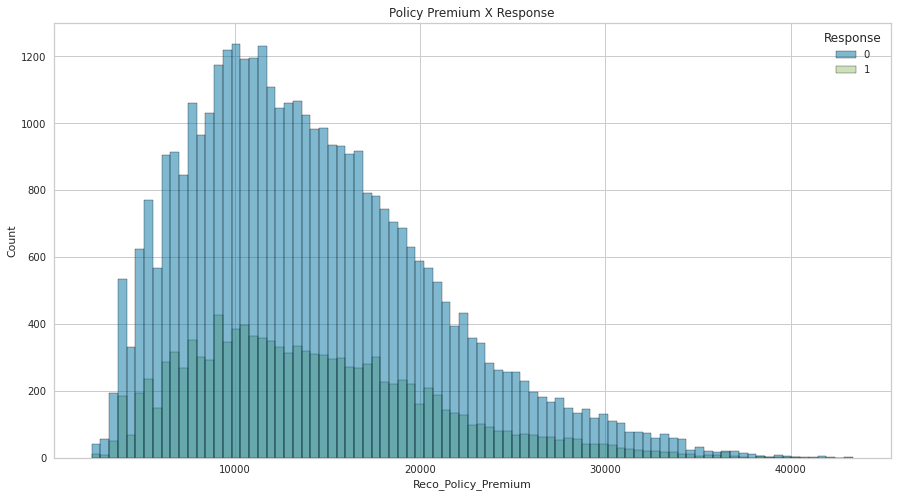

In [26]:
plt.figure(figsize = (15,8))
sns.histplot(data=df, x='Reco_Policy_Premium', hue='Response').set_title('Policy Premium X Response');

O prêmio do seguro segue uma curva normal, enviesada para a esquerda.

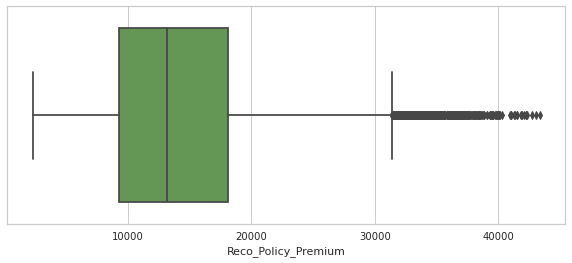

In [27]:
#Checking the ammount of outliers in the policy premium again
plt.figure(figsize = (10,4))
sns.boxplot(x = 'Reco_Policy_Premium', data = df, palette='gist_earth');

O boxplot do quadro acima mostra que prêmios a partir dos 30000 já estão fora do intervalo interquartílico, podendo ser considerados outliers.

In [28]:
#Getting the IQR values to check the number of outliers
Q3 = np.quantile(df['Reco_Policy_Premium'], 0.75)
Q1 = np.quantile(df['Reco_Policy_Premium'], 0.25)
IQR = Q3 - Q1
lower_range = Q1 - (1.5 * IQR)
upper_range = Q3 + (1.5 * IQR)
print(f' The first quartile is: {Q3}. The third Quartile is: {Q1}. The interquartile range is: {IQR}\n The lower bound for outliers is: {lower_range} and the upper bound is {upper_range}')

 The first quartile is: 18096.0. The third Quartile is: 9248.0. The interquartile range is: 8848.0
 The lower bound for outliers is: -4024.0 and the upper bound is 31368.0


In [29]:
outlier_count = 0
for i in df['Reco_Policy_Premium']:
    if i > upper_range:
        outlier_count += 1
print(f'There are {outlier_count} outliers in Reco_Policy_Premium.\nThis represents {(outlier_count/df.shape[0])*100:.2f}% of the entries.')

There are 821 outliers in Reco_Policy_Premium.
This represents 1.61% of the entries.


Após obter o número de outliers, verifica-se que existem alguns na política recomendada. O modelo poderá se beneficiar da retirada deles.

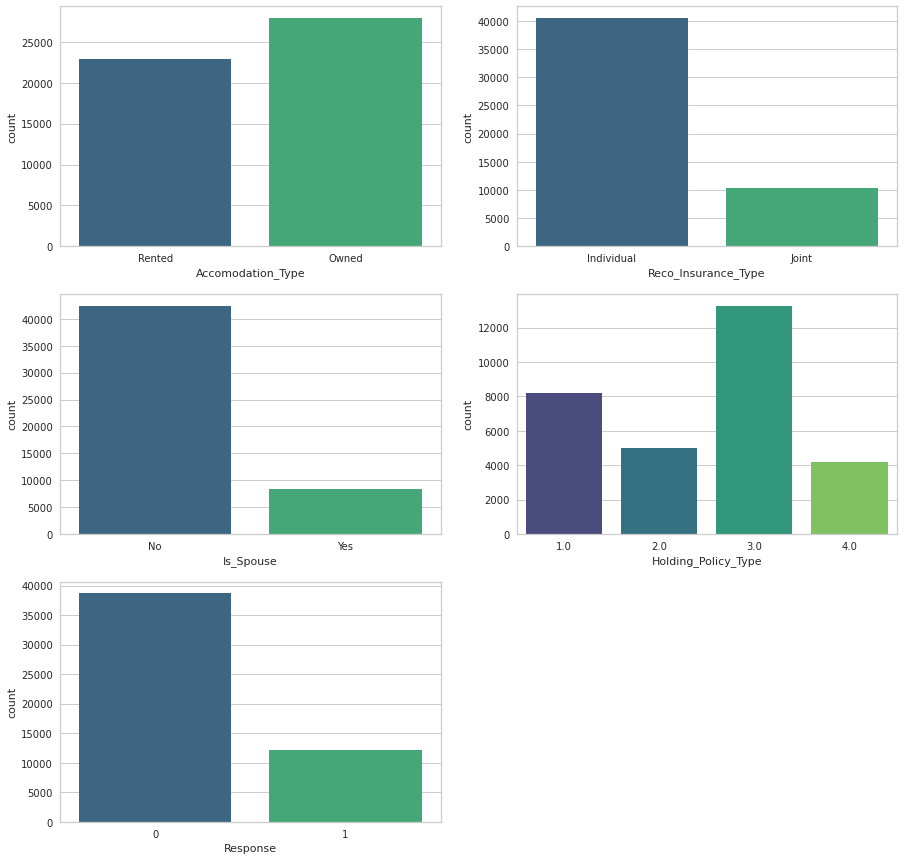

In [30]:
#Measuring the categorical variables
plt.figure(figsize = (15,15))

plt.subplot(3,2,1)
sns.countplot(x = 'Accomodation_Type', palette='viridis', data = df)

plt.subplot(3,2,2)
sns.countplot(x = 'Reco_Insurance_Type', palette='viridis', data = df)

plt.subplot(3,2,3)
sns.countplot(x = 'Is_Spouse', palette='viridis', data = df)

plt.subplot(3,2,4)
sns.countplot(x = 'Holding_Policy_Type', palette='viridis', data = df)

plt.subplot(3,2,5)
sns.countplot(x = 'Response', palette='viridis', data = df);

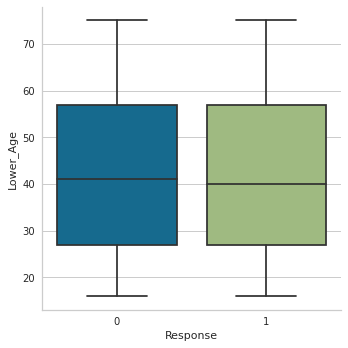

In [31]:
sns.catplot(x = 'Response', y="Lower_Age", kind="box", data=df);

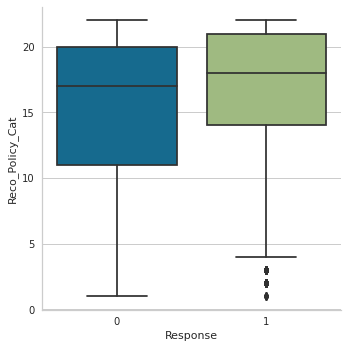

In [32]:
sns.catplot(x = 'Response', y="Reco_Policy_Cat", kind="box", data=df);

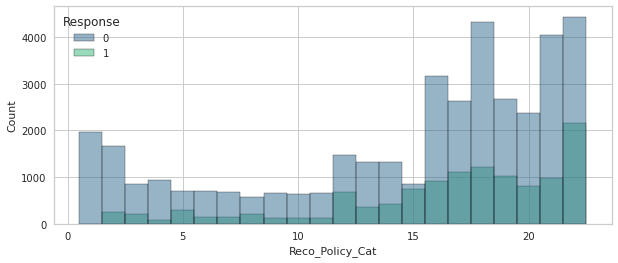

In [33]:
#Rechecking the distribution of the categories for Reco_Policy_Cat
plt.figure(figsize = (10,4))
sns.histplot(x = 'Reco_Policy_Cat', hue='Response', data = df, palette='viridis', discrete='True');

Apesar de alguns outliers na categoria com valores positivos para a categoria de seguro, os dados em geral estão bem distribuídos, não havendo necessidade de removê-los.

In [34]:
#Checking how many times Upper_Age and Lower_Age has the same value
same_rows = 0
for i in range(len(df)):
    if df.loc[i][4] == df.loc[i][5]:
        same_rows += 1

print(f'From the {df.shape[0]} rows of the dataset, Upper_Age equals Lower_Age {same_rows} ({(same_rows/df.shape[0])*100:.2f}%) times.')

From the 50882 rows of the dataset, Upper_Age equals Lower_Age 40536 (79.67%) times.


Após verificar, apenas 20,33% dos valores de Lower_Age e Upper_Age são diferentes.

In [35]:
#Checking if the same values are missing from Holding_Policy_Duration and Holding_Policy_Type
both_na = 0
single_na = 0
for i in range(len(df)):
    if pd.isnull(df.loc[i]['Holding_Policy_Duration']) and pd.isnull(df.loc[i]['Holding_Policy_Type']):
        both_na += 1
    elif pd.isnull(df.loc[i]['Holding_Policy_Duration']) or pd.isnull(df.loc[i]['Holding_Policy_Type']):
        single_na += 1     
print(f'From the {both_na+single_na} NaN entries, {both_na} times both were missing, and {single_na} times only one was missing.')

From the 20251 NaN entries, 20251 times both were missing, and 0 times only one was missing.


OS dados de Holding_Policy_Duration e Holding_Policy_Type sempre estão faltando em conjunto.

Considerando que o plano é oferecerido para se tornar uma lead de vendas, uma explicação possível é que se trate de algum visitante que ainda não tem plano com a seguradora ainda.

Partindo dessa ***presunção*** pode ser mais significativo preencher os valores NaN faltantes com 0, invés de outro valor como mediana ou moda.

## 2.3 Pré-processamento e feature engineering

*Is_Spouse*, *Reco_Insurance_Type*, *Accomodation_Type* são variáveis categóricas apenas. Vamos substituí-las por valores numéricos de 0 e 1.<br>

In [36]:
#Storing datasets for comparison
datasets = {}
datasets['original'] = df.copy()

In [37]:
#Replacing Is_Spouse with 0 or 1
df['Is_Spouse'].replace(('Yes','No'), (1,0), inplace = True)

In [38]:
#Replacing Accomodation_Type with 0 or 1
df['Accomodation_Type'].replace(('Owned','Rented'), (0,1), inplace = True)
df.rename(columns = {'Accomodation_Type':'Has_Own_House'}, inplace = True)

In [39]:
#Replacing Reco_Insurance_Type with 0 or 1
df['Reco_Insurance_Type'].replace(('Individual', 'Joint'), (1,0), inplace = True)
df.rename(columns = {'Reco_Insurance_Type':'Reco_Individual_Insurance'}, inplace = True)

Ao invés de remover a coluna *Upper_Age* nós vamos criar uma nova coluna chamada *Age_Gap*.<br>
A razão para isso é que várias vezes o valor de Upper_Age é igual a Lower_Age.<br>
Isso significa que a seguradora sabe, com precisão, qual a idade do cliente.<br>
Porém, ao invés de simplesmente eliminar uma, podemos tentar criar essa nova coluna Age_Gap para manter essa informação, mas de maneira menos correlacionada, para não aumentar o viés do modelo.

In [40]:
#Creating the Age_Gap column and dropping the Upper_Age
df['Age_Gap'] = df.apply(lambda row: row.Upper_Age - row.Lower_Age, axis = 1)
df.drop(columns=['Upper_Age'], inplace=True)
df.rename(columns = {'Lower_Age':'Age'}, inplace = True)
datasets['create_age_gap'] = df.copy()

*Holding_Policy_Duration* é na verdade um valor numérico discreto, pois mede em anos o tempo que os clientes estão na seguradora.<br>
O pandas considerou como tipo 'object' pelo valor de 14+ ser uma string.

Podemos mudar de '14+' para 15 para manter a informação de que são valores diferentes.

Como existem vários segurados com 14+, isso poder enviesar o modelo, mas é muito melhor do que criar mais 15 classes categóricas.

In [41]:
#Filling missing values with '0'
df['Holding_Policy_Type'].fillna(value=0, inplace = True)
df['Holding_Policy_Duration'].fillna(value=0, inplace = True)
df['Holding_Policy_Duration'].replace(('14+'), (15.0), inplace = True)

In [42]:
#Converting data types
df['Holding_Policy_Duration'] = df['Holding_Policy_Duration'].astype('float64')
df['Holding_Policy_Duration'] = df['Holding_Policy_Duration'].astype('int64')
df['Holding_Policy_Type'] = df['Holding_Policy_Type'].astype('float64')
df['Holding_Policy_Type'] = df['Holding_Policy_Type'].astype('int64')

Health_Indicator é uma variável categórica.

Nesse caso, usaremos a moda para preencher os faltantes.

In [43]:
df['Health_Indicator'].fillna(df['Health_Indicator'].mode()[0], inplace = True)
df['Health_Indicator']=df['Health_Indicator'].str.replace('X','') #We can just remove the 'X' so we end up with numeric values
df['Health_Indicator'] = df['Health_Indicator'].astype('int64')

In [44]:
#Changing city codes to numeric
df['City_Code']=df['City_Code'].str.replace('C','') #We can just remove the 'X' so we end up with numeric values
df['City_Code'] = df['City_Code'].astype('float64')
df['City_Code'] = df['City_Code'].astype('int64')

In [45]:
#Changing Reco_Policy_Premium to match other datatypes
df['Reco_Policy_Premium'] = df['Reco_Policy_Premium'].astype('int64')

In [46]:
#Reorganizing the dataset columns
df = df[['Age','Age_Gap','Has_Own_House','Is_Spouse','Reco_Individual_Insurance',
         'Reco_Policy_Premium','Holding_Policy_Duration','Holding_Policy_Type',
         'Health_Indicator','Reco_Policy_Cat','City_Code', 'Region_Code', 'Response']]

In [47]:
#Saving the all-numeric data before further processing
datasets['numeric'] = df.copy()

Antes de separar os dados, tem muitos valores categóricos para separar usando o encoder.

Sendo assim é melhor agrupar em bins para facilitar o treinamento.

In [48]:
# Grouping higher indicators into a single group due to low value count
df['Health_Indicator'] = df['Health_Indicator'].replace((5,6,7,8,9),(5,5,5,5,5))
df['Health_Indicator'].value_counts()

1    24701
2    10332
3     6762
4     5743
5     3344
Name: Health_Indicator, dtype: int64

Os indicadores de saúde mais "altos" são presentes como valores minúsculos.<br>
Vamos agrupá-los na categoria mais próxima significativa, no caso, 5.

In [49]:
df['Reco_Policy_Groups'] = pd.qcut(x=df['Reco_Policy_Cat'], q=5, labels=False)
df.drop(columns=['Reco_Policy_Cat'], inplace=True)
df['Reco_Policy_Groups'].value_counts()

1    12844
3    11912
0    10215
2     9309
4     6602
Name: Reco_Policy_Groups, dtype: int64

Agrupando os valores das categorias mais recomendadas em 5 bins.

In [50]:
df['City_Group'] = pd.qcut(x=df['City_Code'], q=5, labels=False)
df.drop(columns=['City_Code'], inplace=True)
df['City_Group'].value_counts()

0    16720
2    10701
4     9824
3     8748
1     4889
Name: City_Group, dtype: int64

Mesma coisa para o grupo de cidades.

In [51]:
df['Region_Group'] = pd.qcut(x=df['Region_Code'], q=20, labels=False)
df.drop(columns=['Region_Code'], inplace=True)
df['Region_Group'].value_counts()

1     2559
6     2558
3     2554
12    2550
10    2550
8     2547
17    2547
0     2545
19    2545
15    2544
16    2543
18    2541
11    2540
13    2540
14    2539
5     2538
7     2537
2     2537
9     2536
4     2532
Name: Region_Group, dtype: int64

Agrupando as regiões em 20 bins.

A maior parte das variáveis categóricas estão agrupadas.

In [52]:
datasets['categoricals_binned'] = df.copy()

In [53]:
#One Hot Encoding the Health_Indicator feature
Health_Indicator_Encoder = pd.get_dummies(df['Health_Indicator'], prefix='Health_Indicator', drop_first=True) #Dropping the first to avoid the dummy variable trap
df = pd.concat([df, Health_Indicator_Encoder], axis = 1)
df = df.drop('Health_Indicator', axis = 1)

In [54]:
#Repeating the process for the City_Group feature
City_Group_Encoder = pd.get_dummies(df['City_Group'], prefix='City_Group', drop_first=True)
df = pd.concat([df, City_Group_Encoder], axis = 1)
df = df.drop('City_Group', axis = 1)

In [55]:
#Again for the Region_Group
Region_Group_Encoder = pd.get_dummies(df['Region_Group'], prefix='Region_Group', drop_first=True)
df = pd.concat([df, Region_Group_Encoder], axis = 1)
df = df.drop('Region_Group', axis = 1)

In [56]:
#Same for Holding_Policy_Type
Holding_Policy_Type_Encoder = pd.get_dummies(df['Holding_Policy_Type'], prefix='Holding_Policy_Type', drop_first=True)
df = pd.concat([df, Holding_Policy_Type_Encoder], axis = 1)
df = df.drop('Holding_Policy_Type', axis = 1)

In [57]:
#Again for Reco_Policy_Groups
Reco_Policy_Groups_Encoder = pd.get_dummies(df['Reco_Policy_Groups'], prefix='Reco_Policy_Groups', drop_first=True)
df = pd.concat([df, Reco_Policy_Groups_Encoder], axis = 1)
df = df.drop('Reco_Policy_Groups', axis = 1)

In [58]:
#Reorganizing the dataset
df = df[['Age', 'Age_Gap', 'Has_Own_House', 'Is_Spouse',
       'Reco_Individual_Insurance', 'Reco_Policy_Premium',
       'Holding_Policy_Duration', 'Health_Indicator_2',
       'Health_Indicator_3', 'Health_Indicator_4', 'Health_Indicator_5',
       'City_Group_1', 'City_Group_2', 'City_Group_3', 'City_Group_4',
       'Region_Group_1', 'Region_Group_2', 'Region_Group_3', 'Region_Group_4',
       'Region_Group_5', 'Region_Group_6', 'Region_Group_7', 'Region_Group_8',
       'Region_Group_9', 'Region_Group_10', 'Region_Group_11',
       'Region_Group_12', 'Region_Group_13', 'Region_Group_14',
       'Region_Group_15', 'Region_Group_16', 'Region_Group_17',
       'Region_Group_18', 'Region_Group_19', 'Holding_Policy_Type_1',
       'Holding_Policy_Type_2', 'Holding_Policy_Type_3',
       'Holding_Policy_Type_4', 'Reco_Policy_Groups_1', 'Reco_Policy_Groups_2',
       'Reco_Policy_Groups_3', 'Reco_Policy_Groups_4','Response']]

In [59]:
#The categorical variables are now one-hot encoded.
#We can save it in this state before we deal with the class imabalance.
datasets['one_hot_encoded'] = df.copy()

In [60]:
#Removing the outliers from Reco_Policy_Premium, we will use this as a comparison to the RobustScaler
Q3 = np.quantile(df['Reco_Policy_Premium'], 0.75)
Q1 = np.quantile(df['Reco_Policy_Premium'], 0.25)
IQR = Q3 - Q1
lower_range = Q1 - (1.5 * IQR)
upper_range = Q3 + (1.5 * IQR)
outlier_removed = [x for x in df['Reco_Policy_Premium'] if ((x > lower_range) & (x < upper_range))]
df = df.loc[df['Reco_Policy_Premium'].isin(outlier_removed)]
datasets['outliers_removed'] = df.copy()

## 2.4 Dimensionamento

Vamos criar um dataset com a variável Reco_Policy_Premium redimensionada para comparar.

In [61]:
#Scaling the features with robust scaler
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

In [62]:
#Rescaling the main dataset
to_scale = datasets['one_hot_encoded'].copy()
to_scale[['Reco_Policy_Premium']] = scaler.fit_transform(to_scale[['Reco_Policy_Premium']])
datasets['one_hot_encoded_rescaled'] = to_scale.copy()
df = to_scale.copy()

## 2.4 Rebalanceamento do dataset

O dataset está muito desbalanceado.

Nós vamos criar mais dois usando o RandomOverSampling e Borderline SMOTE.

In [63]:
#Defining the spliter for ease of use
def df_splitter(dataset, target = 'Response'):
    X_train = dataset.drop(columns=[target])
    y_train = dataset[target].values
#    print(f' X_train shape: {X_train.shape}')
#    print(f' y_train shape: {y_train.shape}')
    return X_train, y_train

In [64]:
#Setting a function to call the rescaler easily for testing other datasets
def oversampler(dataset, target = 'Response'):
    X = dataset.drop(target,axis = 1)
    y = dataset[target]
    ros = RandomOverSampler(random_state=0)
    X, y = ros.fit_resample(X, y)
    dataset = pd.concat([X,y], axis = 1)
    return dataset

In [65]:
#We will try two systems to compare, one with the outliers removed before the rescaling, another still with the outliers
datasets['oversampled+'] = oversampler(datasets['one_hot_encoded_rescaled']).copy()
datasets['oversampled-'] = oversampler(datasets['outliers_removed']).copy()

In [66]:
#Preparing the Borderline SMOTE function
from imblearn.over_sampling import BorderlineSMOTE 

def smoter(dataset, target='Response'):
    X = dataset.drop(target,axis = 1)
    y = dataset[target]
    sm = BorderlineSMOTE(random_state=1216)
    X_res, y_res = sm.fit_resample(X, y)
    y_res = pd.DataFrame(y_res, columns = ['Response']) #SMOTE returns an np array, this converts back to dataframe
    dataset = pd.concat([X_res, y_res], axis = 1)
    return dataset

In [67]:
datasets['smoted+'] = smoter(datasets['one_hot_encoded_rescaled']).copy()
datasets['smoted-'] = smoter(datasets['outliers_removed']).copy()

In [68]:
#Saving the datasets into the bucket
for key in datasets.keys():
    datasets[key].to_csv(f's3://trabalho-ifsp-campinas-interdisciplinar-2022-2/{key}.csv', index = False)

## 3. Comparações finais

Pra uma comparação final, vamos ver a correlação entre os principais datasets.

In [69]:
#Defining the plotting function
def plot_phik_heatmap(dataset,title,annotate=True):
    interval_cols = list(dataset.columns)
    phik_matrix = dataset.phik_matrix(interval_cols = interval_cols)
    plt.figure(figsize = (11,7))
    sns.heatmap(phik_matrix, annot=annotate, cmap='gist_earth_r').set(title=fr'$\Phi_K$ Correlation Heatmap for the {title} dataset');
def plot_global_correlation(dataset,title):
    interval_cols = list(dataset.columns)
    global_correlation, global_labels = dataset.global_phik(interval_cols=interval_cols)
    plt.figure(figsize = (2,6))
    sns.heatmap(global_correlation, xticklabels=[''], yticklabels=global_labels,cmap='gist_earth_r').set(title=fr'Global Correlation ($gK$) for the {title} dataset');

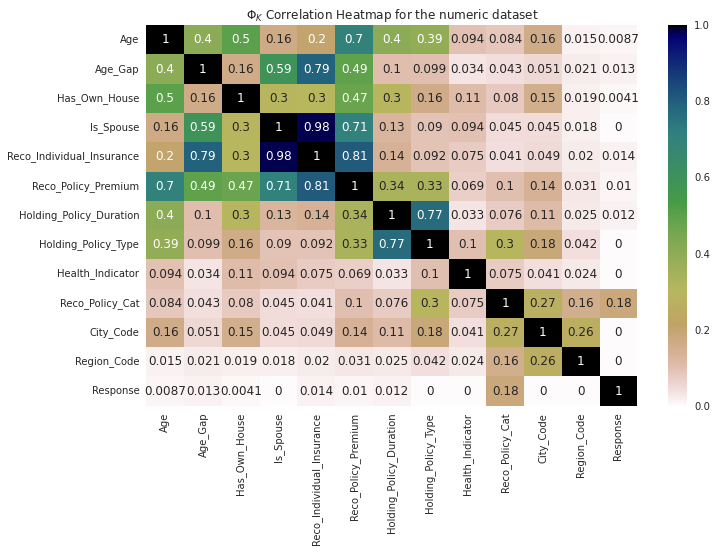

In [70]:
plot_phik_heatmap(datasets['numeric'], title='numeric')

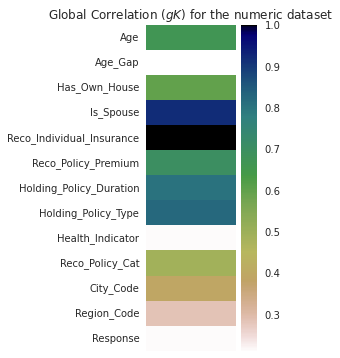

In [71]:
plot_global_correlation(datasets['numeric'],'numeric');

O dataset apenas com os valores numericamente transformados está praticamente igual ao original, com exceção da variável Age_Gap, que não havia primeiramente.

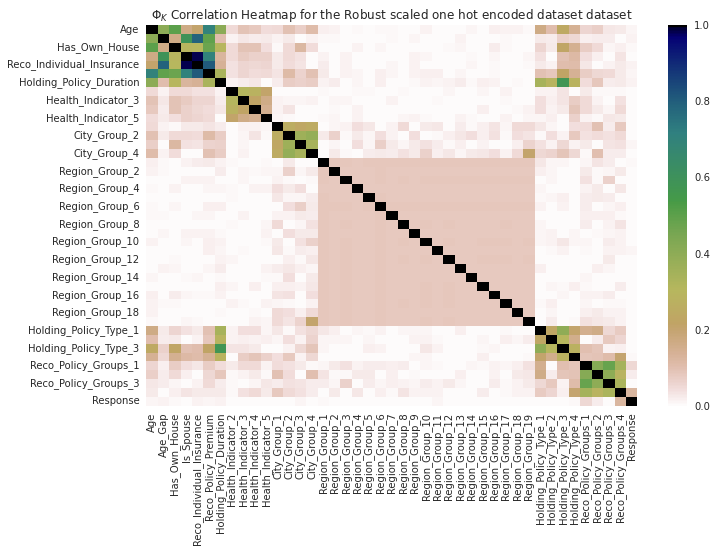

In [72]:
plot_phik_heatmap(datasets['one_hot_encoded_rescaled'], title='Robust scaled one hot encoded dataset',annotate=False)

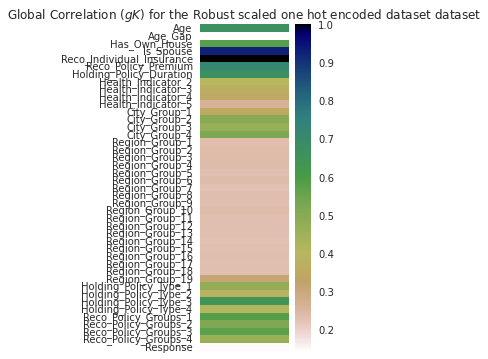

In [73]:
plot_global_correlation(datasets['one_hot_encoded_rescaled'], title='Robust scaled one hot encoded dataset');

O dataset one_hot_encoded apresenta relações similares, com exceção da correlação maior entre os valores que passaram pelo one_hot_encoding.

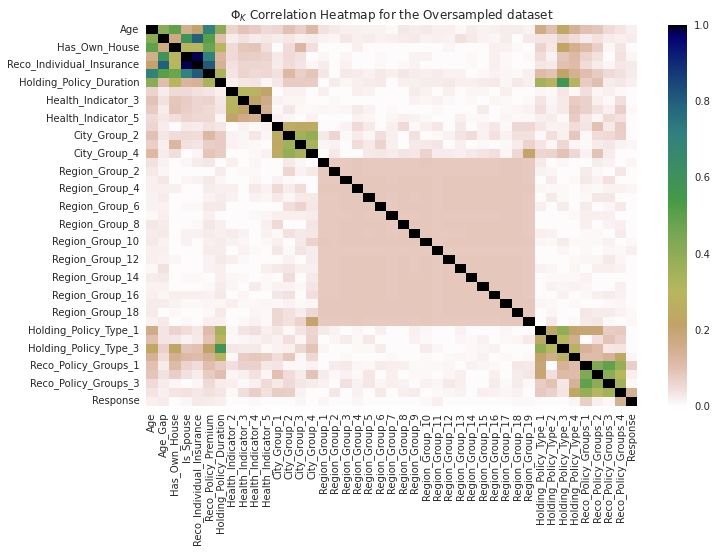

In [74]:
plot_phik_heatmap(datasets['oversampled+'], title='Oversampled', annotate=False)

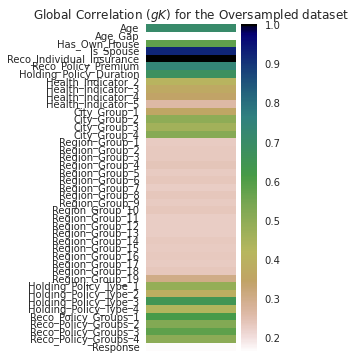

In [75]:
plot_global_correlation(datasets['oversampled+'], title='Oversampled');

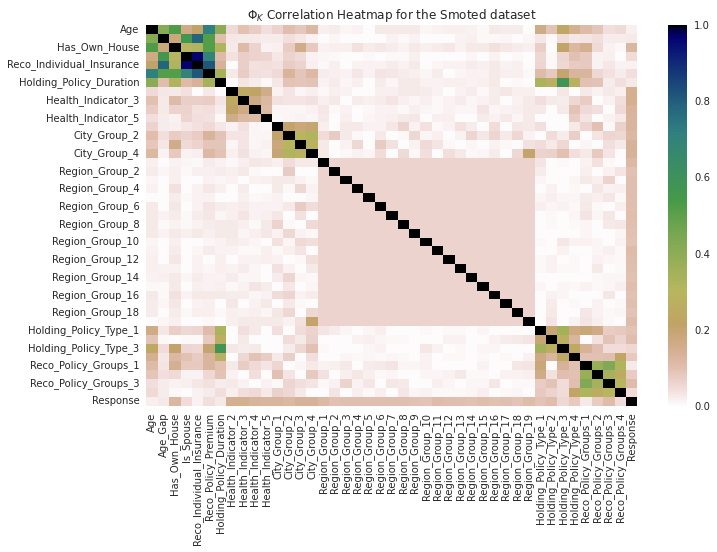

In [76]:
plot_phik_heatmap(datasets['smoted+'], title='Smoted', annotate=False)

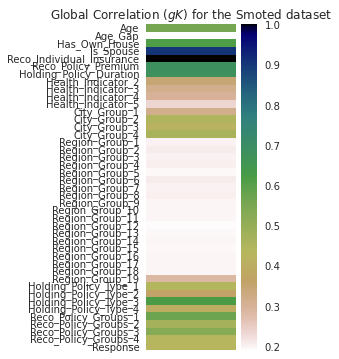

In [77]:
plot_global_correlation(datasets['smoted+'], title='Smoted');

Não há diferenças significativas ente o uso do SMOTE Borderline e Oversampler aleatório, entre as outras features.

Porém no rebalanceamento com o SMOTE Borderline, há uma correlação maior com o valor de resposta.

Após esse processamento, ficamos com os seguintes datasets:

 | Nome | Descrição | 
 | --- | --- |
 | original | Dataset original | 
 | create_age_gap | Dataset substituindo o valor de idade  | 
 | numeric | Dataset convertido em valores numéricos apenas | 
 | categoricals_binned | Dataset numérico, mas com as variávies agrupadas em bins | 
 | one_hot_encoded | Dataset numeric, but now with the features one hot encoded | 
 | outliers_removed | Igual ao one_hot_encoded,mas com os outliers removidos | 
 | one_hot_encoded_rescaled | Igual ao one_hot_encoded, mas com os outliers reescalados usando o Robust Scaler | 
 | oversampled+ | Igual ao one_hot_encoded_rescaled, usando o random oversampler para reequilibrar | 
 | oversampled- | Igual ao outliers_removed dessa vez usando o random oversampler para reequilibrar  | 
 | smoted+ | Igual ao one_hot_encoded_rescaled rebalanceado com o SMOTE Borderline | 
 | smoted- | Igual ao outliers_removed rebalanceado com o SMOTE Borderline | 